# Session 2: Portfolio optimization

This notebook contains the scripts needed to generate the figures of Session 2: Portfolio optimization. 

If you want a step-by-step guide, please refer to Tutorial 1 (Moodle). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.optimize as sco

import warnings
warnings.filterwarnings("ignore")

os.chdir(r'/Users/christophe/OneDrive - ICHEC/Documents/Cours/PortfolioManagement')

from scripts.utils import compute_portfolio_volatility, compute_portfolio_rets 
from scripts.utils import annualize_rets

%load_ext autoreload
%autoreload 2

## Minimum variance portfolio 

A particular portfolio is the minimum variance portfolio. This optimization problem consists in finding the weights such that the portfolio will have the minimum variance. 

### 2 stocks

Before the optimization, let's create an equally-weighted portfolio to have a benchmark to compare with. With $N$ stocks, the equally-weighted weight is therefore $1/N$. 

In [2]:
df = pd.read_excel('data/DJIA_monthly.xlsx', 
                   index_col=0, 
                   parse_dates=True, 
                   sheet_name='prices')
frequency = 12 

stock1 = df.columns[0]
stock2 = df.columns[1]
stocks = [stock1, stock2]

rets = df[stocks].pct_change().dropna()
AnnR = annualize_rets(rets, frequency)
cov = rets.cov(ddof=1)
weights = np.repeat(1/len(stocks), len(stocks))

portfolio_rets = AnnR @ weights
portfolio_vol  = compute_portfolio_volatility(weights, rets)

print('Stock 1:', stock1)
print('Stock 2:', stock2)
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))

Stock 1: GS.N
Stock 2: NKE.N
Portfolio R: 11.69%
Portfolio V: 22.62%


We can also "naively" compute the portfolio return and the portfolio volatility for different weights. 

In [3]:
weights = np.arange(0.0, 1.01, 0.05)
Vols = []
Rets = []
print('%9s %9s %9s %9s' % ('w_1', 'w_2', 'sigma', 'rets'))
print(40 * '-')
for weight in weights:
    W = np.array([weight, 1-weight])
    r = AnnR @ W
    vol = compute_portfolio_volatility(W, rets)
    Vols.append(vol)
    Rets.append(r)
    msg = '{:10.2%}'.format(W[0])
    msg+= '{:10.2%}'.format(W[1])
    msg+= '{:10.2%}'.format(vol)
    msg+= '{:10.2%}'.format(r)
    print(msg)

      w_1       w_2     sigma      rets
----------------------------------------
     0.00%   100.00%    24.28%    16.69%
     5.00%    95.00%    23.72%    16.19%
    10.00%    90.00%    23.24%    15.69%
    15.00%    85.00%    22.85%    15.19%
    20.00%    80.00%    22.54%    14.69%
    25.00%    75.00%    22.32%    14.19%
    30.00%    70.00%    22.19%    13.69%
    35.00%    65.00%    22.16%    13.19%
    40.00%    60.00%    22.22%    12.69%
    45.00%    55.00%    22.38%    12.19%
    50.00%    50.00%    22.62%    11.69%
    55.00%    45.00%    22.96%    11.19%
    60.00%    40.00%    23.38%    10.69%
    65.00%    35.00%    23.89%    10.19%
    70.00%    30.00%    24.47%     9.69%
    75.00%    25.00%    25.11%     9.19%
    80.00%    20.00%    25.83%     8.69%
    85.00%    15.00%    26.60%     8.19%
    90.00%    10.00%    27.43%     7.69%
    95.00%     5.00%    28.31%     7.19%
   100.00%     0.00%    29.24%     6.69%


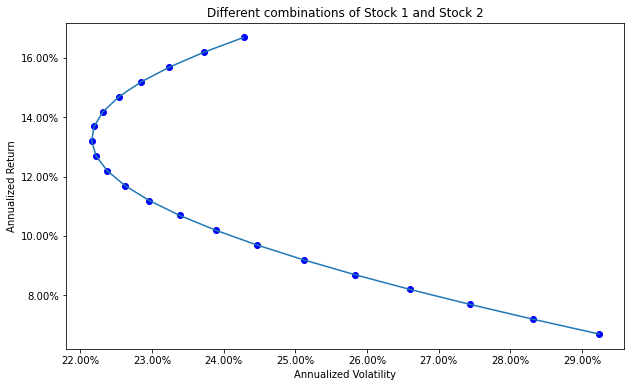

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(Vols, Rets)
ax.scatter(Vols, Rets, color='blue')
plt.title('Different combinations of Stock 1 and Stock 2')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.savefig('images/efficient_frontier_2stocks.png')
plt.show();

#### First method (derivatives)

- Take the derivative of the function and set it to zero. 

$$\frac{d\sigma^2_P}{dw_1} = 0$$ 

The solution is: 

$$ w_1^* = \frac{\sigma_2^2 - \sigma_{12}}{\sigma_1^2 + \sigma_2^2 - 2\sigma_{12}}$$

and

$$ w_2^* = 1 - w_1^* $$ 

In [5]:
var1 = cov[stock1][stock1]
var2 = cov[stock2][stock2]
cov12 = cov[stock1][stock2]
w1 = (var2 - cov12) / (var1 + var2 - 2*cov12)
w2 = 1 - w1
weights = np.array([w1, w2])
r_min_vol = AnnR @ weights
min_vol = compute_portfolio_volatility(weights, rets)
print('Weight 1:', '{:,.2%}'.format(w1))
print('Weight 2:', '{:,.2%}'.format(w2))
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))

Weight 1: 34.22%
Weight 2: 65.78%
Portfolio R: 11.69%
Portfolio V: 22.62%


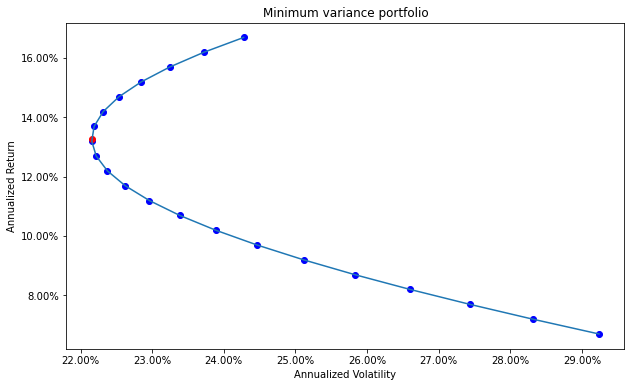

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(Vols, Rets)
ax.scatter(Vols, Rets, color='blue')
ax.scatter(min_vol, r_min_vol, color='red')
plt.title('Minimum variance portfolio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.savefig('images/02_minimum_variance_portfolio.png')
plt.show();

### N stocks

Before the optimization, let's create an equally-weighted portfolio to have a benchmark to compare with. With $N$ stocks, the equally-weighted weight is therefore $1/N$. 

In [7]:
df = pd.read_excel('data/DJIA_monthly.xlsx', 
                   index_col=0, 
                   parse_dates=True, 
                   sheet_name='prices')
frequency = 12 

stock1 = df.columns[0]
stock2 = df.columns[1]
stock3 = df.columns[2]
stocks = [stock1, stock2, stock3]

rets = df[stocks].pct_change().dropna()
AnnR = annualize_rets(rets, frequency)
cov = rets.cov(ddof=1)
weights = np.repeat(1/len(stocks), len(stocks))

portfolio_rets = AnnR @ weights
portfolio_vol  = compute_portfolio_volatility(weights, rets)

print('Stock 1:', stock1)
print('Stock 2:', stock2)
print('Stock 3:', stock3)
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))

Stock 1: GS.N
Stock 2: NKE.N
Stock 3: CSCO.OQ
Portfolio R: 9.79%
Portfolio V: 21.00%


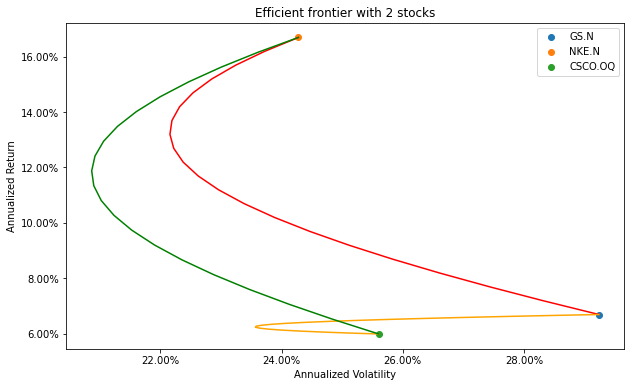

In [8]:
def generate_efficient_frontier(s1, s2, rets):
    W = np.arange(0.0, 1.01, 0.05)
    Vols = []
    Rets = []
    for w in W:
        weights = np.array([w, 1-w])
        r = AnnR[[s1, s2]] @ weights
        vol = compute_portfolio_volatility(weights, rets[[s1, s2]])
        Vols.append(vol)
        Rets.append(r)
    return Vols, Rets
        
V1, R1 = generate_efficient_frontier(stock1, stock2, rets)
V2, R2 = generate_efficient_frontier(stock1, stock3, rets)
V3, R3 = generate_efficient_frontier(stock2, stock3, rets)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(V1, R1, color='red')
ax.plot(V2, R2, color='orange')
ax.plot(V3, R3, color='green')

cov = rets.cov()
for i in range(3):
    for j in range(3):
        if i == j:
            v = cov[stocks[i]][stocks[i]]**0.5*np.sqrt(frequency)
            r = AnnR[stocks[i]]
            plt.scatter(v, r, label=stocks[i])

plt.title('Efficient frontier with 2 stocks')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])

plt.savefig('images/02_efficient_frontier_2by2.png')
plt.show();

#### Random weights

What happens if we create a portfolio with 3 stocks? Let's generate 1,000 simulations with random weights for the 3 stocks. We ensure that these weights sum to one. 

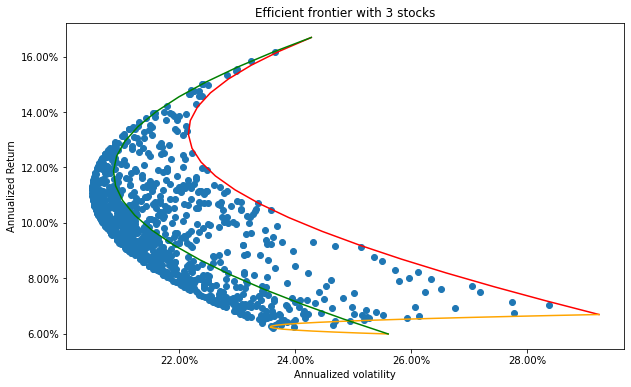

In [9]:
W = np.arange(0.0, 1.01, 0.05)
Vols = []
Rets = []
AnnR = annualize_rets(rets, frequency)
for i in range(1000):
    weights = np.random.random(3)
    weights /= np.sum(weights)
    r = AnnR @ weights
    vol = compute_portfolio_volatility(weights, rets)
    Vols.append(vol)
    Rets.append(r)

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(V1, R1, color='red');
plt.plot(V2, R2, color='orange');
plt.plot(V3, R3, color='green');

plt.scatter(Vols, Rets)
plt.title('Efficient frontier with 3 stocks')
plt.xlabel('Annualized volatility')
plt.ylabel('Annualized Return')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])

plt.savefig('images/efficient_frontier_3stocks.png')
plt.show()

#### Analytical solution

In [10]:
def minimum_variance_portfolio(rets):
    n = rets.shape[1]
    ones = np.ones(n).reshape((-1, 1))
    cov = np.cov(np.array(rets).T)
    
    num = np.linalg.inv(cov) @ ones
    den = ones.T @ np.linalg.inv(cov) @ ones 
    
    opt_weights = num / den
    
    return opt_weights.ravel()

In [11]:
opt_weights = minimum_variance_portfolio(rets)
portfolio_rets = AnnR @ opt_weights
portfolio_vol = compute_portfolio_volatility(opt_weights, rets)
for i in range(len(opt_weights)):
    print(f'Stock {i+1}:', '{:,.2%}'.format(opt_weights[i]))
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))

Stock 1: 16.06%
Stock 2: 47.45%
Stock 3: 36.49%
Portfolio R: 11.18%
Portfolio V: 20.49%


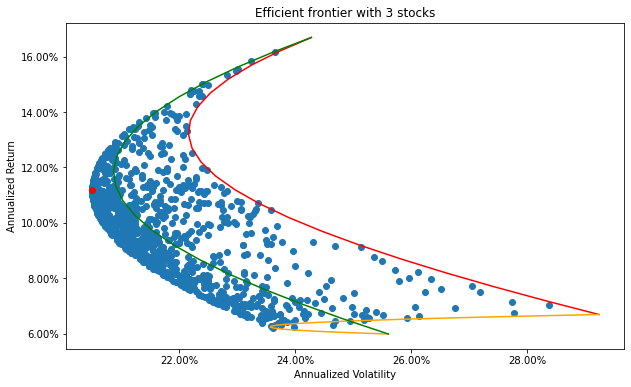

In [12]:
gmv_weights = minimum_variance_portfolio(rets)
gmv_weights = gmv_weights.ravel()
gmv_vol = compute_portfolio_volatility(gmv_weights, rets)
AnnR = annualize_rets(rets, frequency)
gmv_rets = AnnR @ gmv_weights

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(V1, R1, color='red');
plt.plot(V2, R2, color='orange');
plt.plot(V3, R3, color='green');
plt.scatter(Vols, Rets)
plt.scatter(gmv_vol, gmv_rets, color='red')
plt.title('Efficient frontier with 3 stocks')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.savefig('images/efficient_frontier_3stocks_gmv.png')
plt.show()

#### Numerical optimization

In [13]:
n = rets.shape[1]
cons = ({'type': 'eq', 'fun':lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(n))
init_weights = np.repeat(1.0/n, n)
opts = sco.minimize(compute_portfolio_volatility, 
                    init_weights,
                    method='SLSQP', 
                    bounds=bnds,
                    args=(rets),
                    constraints=cons,
                    tol=1e-15)

print(opts)

     fun: 0.20487438241457684
     jac: array([0.20487438, 0.20487438, 0.20487439])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.16058805, 0.47447539, 0.36493656])


In [14]:
opt_weights = opts.x
portfolio_rets = AnnR @ opt_weights
portfolio_vol = compute_portfolio_volatility(opt_weights, rets)
for i in range(len(opt_weights)):
    print(f'Stock {i+1}:', '{:,.2%}'.format(opt_weights[i]))
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))

Stock 1: 16.06%
Stock 2: 47.45%
Stock 3: 36.49%
Portfolio R: 11.18%
Portfolio V: 20.49%


## Sharpe ratio optimization

The optimal portfolio is the one who earns the highest return in excess of the risk free rate per unit of risk. 

The Sharpe Ratio of a portfolio is:

$$ \text{Sharpe Ratio} = \frac{R_P - r_f}{\sigma_P} $$

We take the assumption that the risk-free rate is 0.5%. 

### 2 stocks 

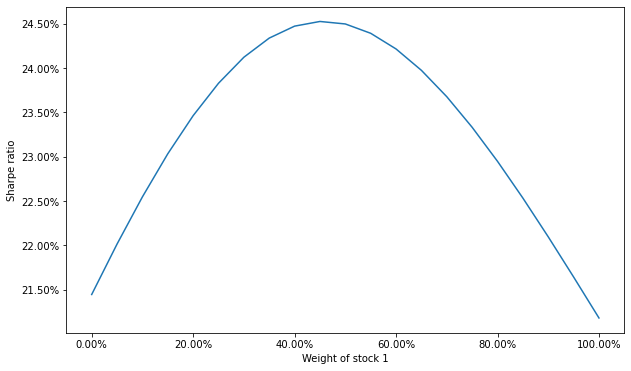

In [15]:
df = pd.read_excel('data/DJIA_monthly.xlsx', 
                   index_col=0, 
                   parse_dates=True, 
                   sheet_name='prices')
frequency = 12 

stock1 = df.columns[0]
stock2 = df.columns[2]
stocks = [stock1, stock2]

rets = df[stocks].pct_change().dropna()
AnnR = annualize_rets(rets, frequency)
cov = rets.cov(ddof=1)
weights = np.repeat(1/len(stocks), len(stocks))

weights = np.arange(0.0, 1.01, 0.05)
Vols = []
Rets = []
for weight in weights:
    W = np.array([weight, 1-weight])
    r = (W[0] * AnnR[stock1]) + (W[1]*AnnR[stock2])
    vol = compute_portfolio_volatility(W, rets)
    Vols.append(vol)
    Rets.append(r)

rf = 0.005
sharpe_ratio_2stocks = (np.array(Rets)-rf)/np.array(Vols)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(weights, sharpe_ratio_2stocks)
ax.set_ylabel('Sharpe ratio')
ax.set_xlabel('Weight of stock 1')
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.savefig('images/02_sharpe_ratio.png')
plt.show();

We see that at some point, the increase in return is not sufficient to compensate for the increase in volatility. Therefore the plot reaches a maximum. 

#### Analytical solution

$$ w = \frac{\Sigma^{-1} [E(R) - r_f  1_N]}{1_N^{'} \Sigma^{-1} [E(R) - r_f  1_N]} $$ 

In [16]:
def sharpe_ratio(weights, rets, rf):
    # numerator 
    AnnR = annualize_rets(rets, frequency)
    p_return = weights @ AnnR 
    p_excess_return = p_return - rf
    # denominator 
    p_volatility = compute_portfolio_volatility(weights, rets)
    sharpe_ratio = p_excess_return / p_volatility
    return sharpe_ratio

def sharpe_analytical(rets, rf):
    n = rets.shape[1] # number of stocks 
    cov = np.cov(rets.T)
    cov_inv = np.linalg.inv(cov)
    ExpR = annualize_rets(rets, frequency)
    ExpR = np.array(ExpR).reshape((-1, 1))
    num = np.linalg.inv(cov) @ (ExpR - rf * np.ones(n).reshape((-1, 1)))
    den = np.ones(n) @ np.linalg.inv(cov) @ (ExpR - rf * np.ones(n).reshape((-1, 1)))
    opt_weights = num / den
    opt_weights = opt_weights.ravel()
    return opt_weights

opt_weights = sharpe_analytical(rets, rf)
portfolio_rets = AnnR @ opt_weights
portfolio_vol = compute_portfolio_volatility(opt_weights, rets)
portfolio_sr = sharpe_ratio(opt_weights, rets, rf)
for i in range(len(opt_weights)):
    print(f'Stock {i+1}:', '{:,.2%}'.format(opt_weights[i]))
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))
print('Portfolio SR:', '{:,.4}'.format(portfolio_sr))

Stock 1: 45.73%
Stock 2: 54.27%
Portfolio R: 6.31%
Portfolio V: 23.69%
Portfolio SR: 0.2453


#### Numerical optimization

In [17]:
def min_sharpe_ratio(weights, rets, rf):
    return - sharpe_ratio(weights, rets, rf)

def sharpe_numerical(rets, rf, short_selling=True):
    n = rets.shape[1]
    cons = ({'type': 'eq', 'fun':lambda x: np.sum(x) - 1})
    if short_selling==True:
        bnds = None
    else:
        bnds = tuple((0,1) for x in range(n))
    init_weights = np.repeat(1.0/n, n)
    opts = sco.minimize(min_sharpe_ratio, 
                        init_weights,
                        method='SLSQP', 
                        bounds=bnds,
                        args=(rets, rf),
                        constraints=cons)

    SR_weights = opts.x
    return SR_weights

Stock 1: 45.72%
Stock 2: 54.28%
Portfolio R: 6.31%
Portfolio V: 23.69%
Portfolio SR: 0.2453


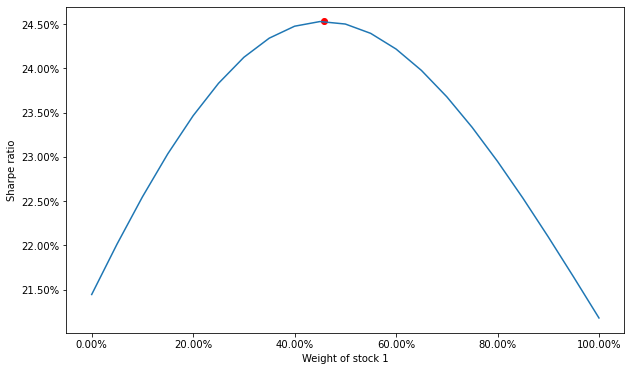

In [18]:
opt_weights = sharpe_numerical(rets, rf)
portfolio_rets = AnnR @ opt_weights
portfolio_vol = compute_portfolio_volatility(opt_weights, rets)
portfolio_sr = sharpe_ratio(opt_weights, rets, rf)
for i in range(len(opt_weights)):
    print(f'Stock {i+1}:', '{:,.2%}'.format(opt_weights[i]))
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))
print('Portfolio SR:', '{:,.4}'.format(portfolio_sr))

sharpe_ratio_2stocks = (np.array(Rets)-rf)/np.array(Vols)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(weights, sharpe_ratio_2stocks)
plt.scatter(opt_weights[0], portfolio_sr, color='red')
ax.set_ylabel('Sharpe ratio')
ax.set_xlabel('Weight of stock 1')
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
fig.savefig('images/02_sharpe_ratio_opt.png')
plt.show();

### N stocks 

In [19]:
df = pd.read_excel('data/DJIA_monthly.xlsx', 
                   index_col=0, 
                   parse_dates=True, 
                   sheet_name='prices')
frequency = 12 

stock1 = df.columns[0]
stock2 = df.columns[1]
stock3 = df.columns[2]
stocks = [stock1, stock2, stock3]

rets = df[stocks].pct_change().dropna()
AnnR = annualize_rets(rets, frequency)

#### Analytical solution

$$ w = \frac{\Sigma^{-1} [E(R) - r_f  1_N]}{1_N^{'} \Sigma^{-1} [E(R) - r_f  1_N]} $$ 

In [20]:
opt_weights = sharpe_analytical(rets, rf)
portfolio_rets = AnnR @ opt_weights
portfolio_vol = compute_portfolio_volatility(opt_weights, rets)
portfolio_sr = sharpe_ratio(opt_weights, rets, rf)
for i in range(len(opt_weights)):
    print(f'Stock {i+1}:', '{:,.2%}'.format(opt_weights[i]))
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))
print('Portfolio SR:', '{:,.4}'.format(portfolio_sr))

Stock 1: -9.70%
Stock 2: 115.32%
Stock 3: -5.63%
Portfolio R: 18.26%
Portfolio V: 26.42%
Portfolio SR: 0.6722


#### Numerical solution 

- If short selling is allowed

In [21]:
opt_weights = sharpe_numerical(rets, rf)
portfolio_rets = AnnR @ opt_weights
portfolio_vol = compute_portfolio_volatility(opt_weights, rets)
portfolio_sr = sharpe_ratio(opt_weights, rets, rf)
for i in range(len(opt_weights)):
    print(f'Stock {i+1}:', '{:,.2%}'.format(opt_weights[i]))
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))
print('Portfolio SR:', '{:,.4}'.format(portfolio_sr))

Stock 1: -9.79%
Stock 2: 115.45%
Stock 3: -5.66%
Portfolio R: 18.27%
Portfolio V: 26.44%
Portfolio SR: 0.6722


- With short selling constraint

In [22]:
opt_weights = sharpe_numerical(rets, rf, short_selling=False)
portfolio_rets = AnnR @ opt_weights
portfolio_vol = compute_portfolio_volatility(opt_weights, rets)
portfolio_sr = sharpe_ratio(opt_weights, rets, rf)
for i in range(len(opt_weights)):
    print(f'Stock {i+1}:', '{:,.2%}'.format(opt_weights[i]))
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))
print('Portfolio SR:', '{:,.4}'.format(portfolio_sr))

Stock 1: 0.00%
Stock 2: 100.00%
Stock 3: 0.00%
Portfolio R: 16.69%
Portfolio V: 24.28%
Portfolio SR: 0.6669


## Efficient frontier 

Can also be viewed as minimizing the variance of the portfolio with an additional constraint on the expected return:

In [23]:
def minimum_variance_portfolio(rets, ReturnConstraint=None):
    n = rets.shape[1]
    AnnRets = annualize_rets(rets, frequency)
    
    if ReturnConstraint is None:
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    else:
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: x @ AnnRets - ReturnConstraint })
    bnds = tuple((0,1) for x in range(n))
    init_weights = np.repeat(1.0/n, n)
    opts = sco.minimize(compute_portfolio_volatility, 
                        init_weights,
                        method='SLSQP', 
                        bounds=bnds,
                        args=(rets),
                        constraints=cons,
                        tol=1e-15)
    
    return opts.x 

* Optimization without constraint on the portfolio return

In [24]:
opt_weights = minimum_variance_portfolio(rets)
portfolio_rets = AnnR @ opt_weights
portfolio_vol = compute_portfolio_volatility(opt_weights, rets)
portfolio_sr = sharpe_ratio(opt_weights, rets, rf)
for i in range(len(opt_weights)):
    print(f'Stock {i+1}:', '{:,.2%}'.format(opt_weights[i]))
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))
print('Portfolio SR:', '{:,.4}'.format(portfolio_sr))

Stock 1: 16.06%
Stock 2: 47.45%
Stock 3: 36.49%
Portfolio R: 11.18%
Portfolio V: 20.49%
Portfolio SR: 0.5213


In [25]:
portfolio_sr

0.5212687515403356

* Optimization with constraint on the portfolio return

In [26]:
opt_weights = minimum_variance_portfolio(rets, ReturnConstraint=0.14)
portfolio_rets = AnnR @ opt_weights
portfolio_vol = compute_portfolio_volatility(opt_weights, rets)
portfolio_sr = sharpe_ratio(opt_weights, rets, rf)
for i in range(len(opt_weights)):
    print(f'Stock {i+1}:', '{:,.2%}'.format(opt_weights[i]))
print('Portfolio R:', '{:,.2%}'.format(portfolio_rets))
print('Portfolio V:', '{:,.2%}'.format(portfolio_vol))
print('Portfolio SR:', '{:,.4}'.format(portfolio_sr))

Stock 1: 5.80%
Stock 2: 74.48%
Stock 3: 19.72%
Portfolio R: 14.00%
Portfolio V: 21.54%
Portfolio SR: 0.6268


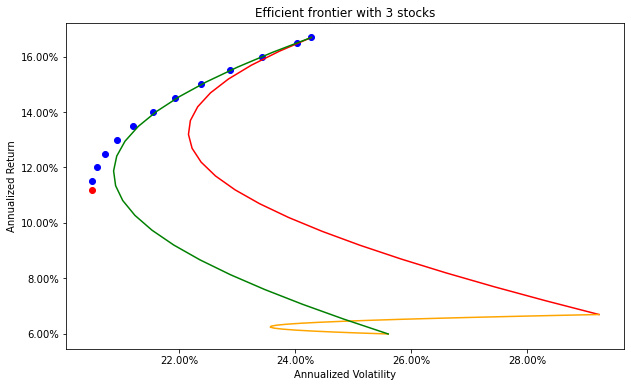

In [27]:
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(V1, R1, color='red');
plt.plot(V2, R2, color='orange');
plt.plot(V3, R3, color='green');

gmv_weights = minimum_variance_portfolio(rets)
gmv_weights = gmv_weights.ravel()
gmv_vol = compute_portfolio_volatility(gmv_weights, rets)
gmv_ret = AnnR @ gmv_weights
plt.scatter(gmv_vol, gmv_ret, color='red')

for r_bar in np.arange(0.115, 0.17, 0.005):
    w_tmp = minimum_variance_portfolio(rets,
                                       ReturnConstraint=r_bar)
    w_vol = compute_portfolio_volatility(w_tmp, rets)
    w_ret = AnnR @ w_tmp
    plt.scatter(w_vol, w_ret, color='blue')
    
plt.title('Efficient frontier with 3 stocks')
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Annualized Return')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])

plt.savefig('images/02_efficient_frontier_3stocks_gmv.png')
plt.show()

## Capital allocation line 

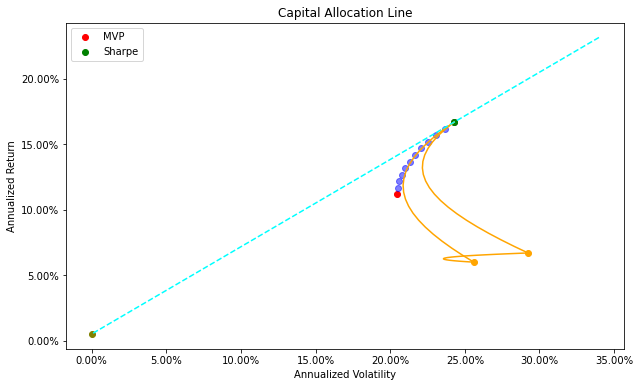

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

# Individual stocks 
for stock in stocks:
    vol = rets[stock].std() * np.sqrt(frequency)
    ret = (1+rets[stock]).prod()**(frequency/rets.shape[0]) - 1
    ax.scatter(vol, ret, color='orange')

# Efficient frontiers 2 by 2 
V1, R1 = generate_efficient_frontier(stock1, stock2, rets=rets)
V2, R2 = generate_efficient_frontier(stock1, stock3, rets=rets)
V3, R3 = generate_efficient_frontier(stock2, stock3, rets=rets)

ax.plot(V1, R1, color='orange')
ax.plot(V2, R2, color='orange')
ax.plot(V3, R3, color='orange')

# Global minimum variance 
gmv_weights = minimum_variance_portfolio(rets)
gmv_weights = gmv_weights.ravel()
gmv_vol = compute_portfolio_volatility(gmv_weights, rets)
gmv_ret = AnnR @ gmv_weights
plt.scatter(gmv_vol, gmv_ret, color='red', label='MVP')

# Efficient frontier 
# Global minimum variance with return constraint 
for r_bar in np.arange(gmv_ret+0.005, 0.17, 0.005):
    w_tmp = minimum_variance_portfolio(rets, ReturnConstraint=r_bar)
    w_vol = compute_portfolio_volatility(w_tmp, rets)
    w_ret = AnnR @ w_tmp
    plt.scatter(w_vol, w_ret, color='blue', alpha=0.5)

# Optimal sharpe ratio 
sharpe_w = sharpe_numerical(rets, rf, short_selling=False)
sharpe_vol = compute_portfolio_volatility(sharpe_w, rets)
sharpe_ret = AnnR @ sharpe_w 
plt.scatter(sharpe_vol, sharpe_ret, label='Sharpe', color='green')

# capital allocation line
plt.scatter(0, rf, color='olive')
CAL_x = []
CAL_y = []
for weight in np.arange(-0.4, 1.01, 0.10):
    vol = (1-weight) * sharpe_vol
    ret = weight * rf + (1-weight) * sharpe_ret
    CAL_x.append(vol)
    CAL_y.append(ret)
plt.plot(CAL_x, CAL_y, linestyle='dashed', color='cyan')

plt.title('Capital Allocation Line')
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Annualized Return')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])

plt.legend(loc=0)
plt.savefig('images/02_capital_allocation_line.png')
plt.show()

## Stock beta

The beta of a stock is computed as the covariance between the stock's excess return ($R^e_i$) and the excess market return ($R^e_m$) divided by the variance of the market return:

$$ \beta_i = \frac{Cov(R^e_i, R^e_m)}{V(R^e_i)} $$

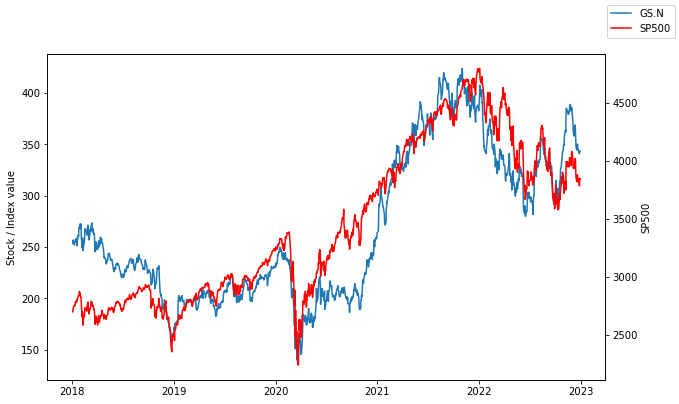

In [29]:
start_date = '2017-12-31'
sp500 = pd.read_excel('data/sp500_daily.xlsx', index_col=0, parse_dates=True, sheet_name='hloc')
stocks = pd.read_excel('data/DJIA_daily.xlsx', index_col=0, parse_dates=True, sheet_name='prices')

# starting at specific time 
stocks = stocks.loc[start_date:]
sp500 = sp500.loc[start_date:]
sp500.rename(columns={'Close': 'SP500'}, inplace=True)
df = pd.concat([sp500, stocks], axis=1)
# plot 
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['GS.N'], label='GS.N')
ax2 = ax.twinx()
ax2.plot(df.index, df['SP500'], label='SP500', color='red')
fig.legend(loc="upper right")
ax.set_ylabel('Stock / Index value')
ax2.set_ylabel('SP500')
plt.savefig('images/02_sp500_gsn.png')
plt.show()

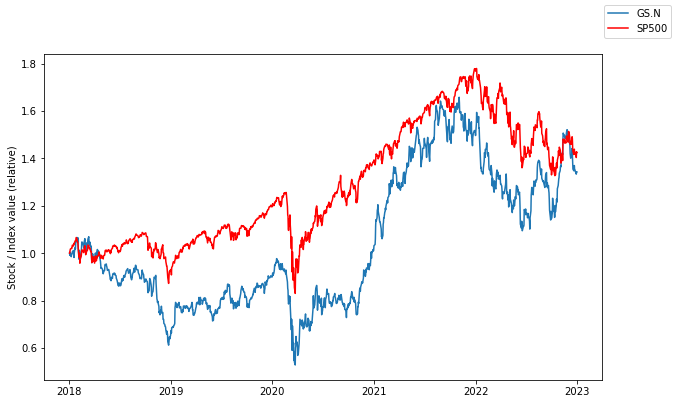

In [30]:
# price normalization 
prices_norm = df / df.iloc[0]
# plot 
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prices_norm.index, prices_norm['GS.N'], label='GS.N')
ax.plot(prices_norm.index, prices_norm['SP500'], label='SP500', color='red')
fig.legend(loc="upper right")
ax.set_ylabel('Stock / Index value (relative)')
plt.savefig('images/02_sp500_gsn_norm.png')
plt.show()

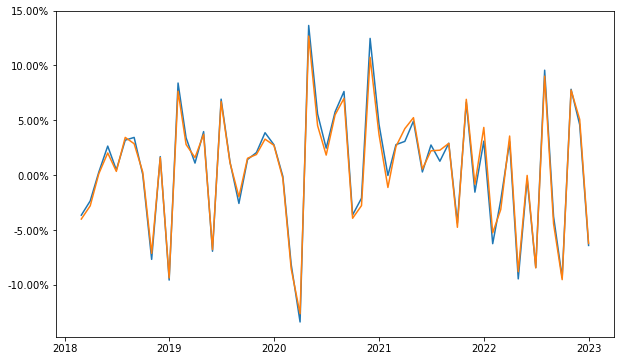

In [31]:
rf = pd.read_excel('data/FF_monthly.xlsx', index_col=0, parse_dates=True)
rf = rf.resample('M').last()
rf = rf.loc[start_date:]
rf = rf / 100 

df = df.resample('M').last()
rets = df.pct_change().dropna()
rets = pd.concat([rf, rets], axis=1)
rets.dropna(inplace=True)
rets['SP500_excess'] = rets['SP500'] - rets['RF']
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(rets['Mkt-RF'])
ax.plot(rets['SP500_excess'])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.savefig('images/02_market_excess_return')
plt.show()

In [32]:
cov_matrix = rets[['GS.N', 'SP500_excess']].cov()
cov_value  = cov_matrix['GS.N']['SP500_excess'] 
var_value = rets['SP500_excess'].var()
beta = cov_value / var_value
print('Beta: ', round(beta, 4))

Beta:  1.4153


### Rolling window 

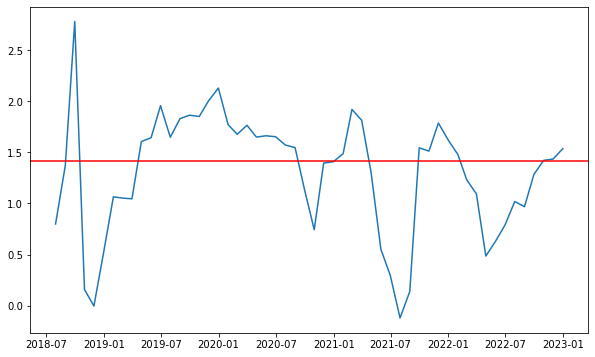

In [33]:
rets['cov6M'] = rets.rolling(6).cov().unstack()['GS.N']['SP500_excess']
rets['var6M'] = rets['SP500_excess'].rolling(6).var()
rets['beta6M'] = rets['cov6M'] / rets['var6M']

plt.figure(figsize=(10,6))
plt.plot(rets['beta6M'])
plt.axhline(beta, color='r')
plt.savefig('images/02_rolling_beta.png')
plt.show();